In [6]:
%precision 4
import pandas as pd
from matplotlib import cm
from pathlib import Path
from fake_gt import *
# pd.set_option('precision', 3)
import numpy as np
import pandas as pd
from ytb_compare import mp_metric_frames
np.set_printoptions(suppress=True)
import mmcv

In [390]:
_results = [
'top1_top2.txt',
'ensemble-all.txt', 
'AOT-COO.txt',
'AOT-uvo_dense-short-384.txt', # 85.0
'85.1.txt',
'AOTv2-interval3.txt', #84.3
'AOTv2-all_frames.txt', #84.3
'stcn-initial-ms.txt', #82.1
'AOTv2-short384.txt',
'ensemble_mask.txt',
]
_Annotations = [
'merge7models',
'stcn-initial-ms', #82.1
'AOTv2-short384_SwinB_AOTL_PRE_UVO_OVIS_YTB_DAV_ckpt_unknown_ema_flip_ms_0dot75_1dot0_1dot4',
'top1_top2',
'noml',
'AOT-coo_ema_flip_ms_0dot75_1dot0_1dot4',
'AOT-uvo_dense-short-384',
'sub_851/sub_851',
'ensemble-AOTv2_85.1-AOTcoo',
'AOTv2-interval3', #84.3
'AOTv2-all_frames',
'v2short-v2pa-coo-v2',
# 'AOTv2-qam',
# 'AOT-uvo-finetune500-new',
'ensemble_mask',
]
ensemble_path = Path('ensemble_v2short_v2pa_coo_v2_stcn_merge7_v2short') / 'Annotations'
results = [Path('results') / x for x in _results]
Annotations = [Path('results') / x for x in _Annotations]


In [324]:
for i,x in enumerate(_results):
    print(i,'\t',x)

0 	 top1_top2.txt
1 	 ensemble-all.txt
2 	 AOT-COO.txt
3 	 AOT-uvo_dense-short-384.txt
4 	 85.1.txt
5 	 AOTv2-interval3.txt
6 	 AOTv2-all_frames.txt
7 	 stcn-initial-ms.txt
8 	 AOTv2-short384.txt
9 	 ensemble_mask.txt


In [322]:
dfs = [read_df(x) for x in results]
scores = [score(x) for x in dfs]
for s in scores:
    print_score(s)
print('| single score')
opt=ensem_video(dfs)
print('| video level pick')
ensem_frame(dfs)
print('| frame level pick')
ensem_opt(dfs)
print('| obj level pick')

85.51  85.51  85.54  85.23  85.16  84.75  84.74  81.33  85.34  85.79  | single score
85.51  85.57  86.25  86.98  87.17  87.49  87.75  88.14  88.25  88.27  | video level pick
85.51  85.58  86.51  87.57  87.89  88.38  88.77  89.59  89.75  89.75  | frame level pick
85.51  85.59  86.61  87.83  88.22  88.76  89.13  90.14  90.31  90.31  | obj level pick


In [372]:
def vote(Annotations, dfs=None):
    nfls = mmcv.load('name_fid_objs.json')
    c01 = mp_metric_frames(Annotations[0],Annotations[1],nfls)
    c12 = mp_metric_frames(Annotations[1],Annotations[2],nfls)
    c20 = mp_metric_frames(Annotations[0],Annotations[2],nfls)
    da = ( pd.DataFrame
            .from_records(c12, columns=['name','frame','obj','iou'])
            .set_index(['name','frame','obj'])
            .groupby(['name','frame'])
            .mean()
            .rename(columns={'iou':'a'})
        )
    db = ( pd.DataFrame
            .from_records(c20, columns=['name','frame','obj','iou'])
            .set_index(['name','frame','obj'])
            .groupby(['name','frame'])
            .mean()
            .rename(columns={'iou':'b'})
        )
    dc = ( pd.DataFrame
            .from_records(c01, columns=['name','frame','obj','iou'])
            .set_index(['name','frame','obj'])
            .groupby(['name','frame'])
            .mean()
            .rename(columns={'iou':'c'})
        )
    cat_sim = pd.concat([da,db,dc],axis=1)
    # video level vote
    # best = cat_sim.groupby(['name']).mean().idxmin(axis=1)
    # tgt = dfs[0].copy().reset_index().set_index('name')
    # tgt.loc[best == 'b'] = dfs[1].reset_index().set_index('name').loc[best == 'b']
    # tgt.loc[best == 'c'] = dfs[1].reset_index().set_index('name').loc[best == 'c']
    # tgt = tgt.reset_index().set_index(['name','frame','obj'])
    # frame level vote
    best = cat_sim.idxmin(axis=1)
    if dfs is None:
        return best
    tgt = dfs[0].copy()
    tgt.loc[best == 'b'] = dfs[1].loc[best == 'b']
    tgt.loc[best == 'c'] = dfs[2].loc[best == 'c']
    # print_score(dfs[0].pipe(score))
    # print_score(dfs[1].pipe(score))
    # print_score(dfs[2].pipe(score))
    sco = tgt.pipe(score)
    return sco,best

In [308]:
results = dict()

In [331]:
sco, best = vote([Annotations[i] for i in [2,5,8]],
    [dfs[i] for i in [2,5,8]])

In [336]:
print_score(sco)

def score(x):
    scores = x.groupby(['name','obj']).mean()
    return scores.mean().item()

85.70  

In [337]:
for i in range(len(Annotations)):
    for j in tqdm(range(i+1,len(Annotations))):
        for k in range(j+1,len(Annotations)):
            if (i,j,k) in results:
                continue
            Ann = [Annotations[x] for x in [i,j,k]]
            dfss = [dfs[x] for x in [i,j,k]]
            sco,best = vote(Ann, dfss)
            print(sco)
            results[i,j,k] = sco

  0%|          | 0/9 [00:46<?, ?it/s]

0.8551639404925282


TypeError: list indices must be integers or slices, not tuple

In [320]:
sorted([[k,v] for k,v in results.items()],key=lambda x:x[1],reverse=True )

[[(2, 5, 8), 0.8587],
 [(2, 3, 4), 0.8581],
 [(2, 3, 5), 0.8581],
 [(2, 3, 7), 0.8579],
 [(2, 7, 8), 0.8579],
 [(1, 2, 7), 0.8578],
 [(2, 3, 6), 0.8577],
 [(2, 3, 8), 0.8577],
 [(0, 2, 3), 0.8577],
 [(0, 2, 7), 0.8576],
 [(0, 7, 8), 0.8575],
 [(1, 7, 8), 0.8575],
 [(1, 2, 3), 0.8575],
 [(0, 3, 5), 0.8574],
 [(2, 4, 8), 0.8574],
 [(1, 2, 8), 0.8573],
 [(0, 2, 8), 0.8573],
 [(1, 3, 5), 0.8572],
 [(2, 6, 8), 0.8571],
 [(3, 7, 8), 0.8570],
 [(1, 3, 7), 0.8570],
 [(0, 3, 7), 0.8570],
 [(2, 4, 7), 0.8570],
 [(0, 3, 8), 0.8569],
 [(0, 3, 6), 0.8569],
 [(1, 3, 8), 0.8568],
 [(1, 3, 6), 0.8568],
 [(0, 2, 5), 0.8567],
 [(1, 2, 5), 0.8566],
 [(1, 5, 8), 0.8564],
 [(1, 3, 4), 0.8563],
 [(0, 5, 8), 0.8563],
 [(3, 6, 8), 0.8562],
 [(2, 6, 7), 0.8562],
 [(2, 5, 7), 0.8562],
 [(0, 3, 4), 0.8561],
 [(0, 2, 6), 0.8560],
 [(3, 4, 8), 0.8559],
 [(1, 2, 6), 0.8559],
 [(0, 6, 8), 0.8556],
 [(0, 4, 8), 0.8556],
 [(1, 4, 8), 0.8556],
 [(3, 4, 7), 0.8556],
 [(2, 4, 5), 0.8554],
 [(1, 6, 8), 0.8554],
 [(0, 1, 3

### do ensemble

In [391]:
best = vote(Annotations[:3])

In [392]:
import shutil
from tqdm import tqdm
best_frame = best.to_dict()
for (name,fid),l in tqdm(best_frame.items()):
    ftgt = ensemble_path / name / f'{fid:05d}.png'
    ftgt.parent.mkdir(exist_ok=True, parents=True)
    i = {'a':0,'b':1,'c':2}[l]
    fsrc = Annotations[i] / 'Annotations' / name / f'{fid:05d}.png'
    shutil.copy(fsrc, ftgt)

100%|██████████| 25137/25137 [00:02<00:00, 8695.06it/s]


In [339]:
df = read_df(results[-1])

In [354]:
pixs =[]
for i in tqdm(df.index):
    pix = (read_mask('results/ensemble_mask',i[0],i[1]) == i[2]).sum()
    pixs.append(pix)

100%|██████████| 42006/42006 [02:08<00:00, 326.89it/s]


<AxesSubplot:xlabel='pix', ylabel='JF'>

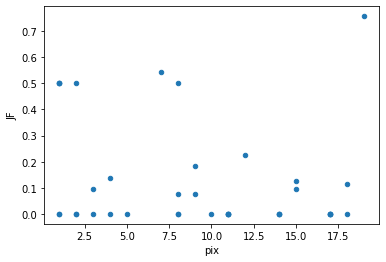

In [370]:
df.assign(pix=pixs).query('0 < pix < 20').plot.scatter('pix','JF')

<AxesSubplot:xlabel='pix', ylabel='JF'>

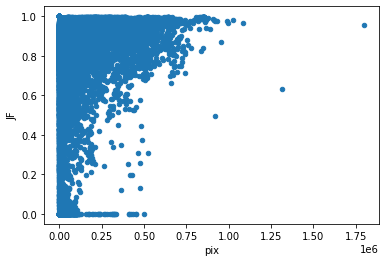

In [358]:
df.plot.scatter('pix','JF')

In [345]:
from ytb_compare import *

75062